In [1]:
import mne
import numpy as np
import pandas as pd
from mne.stats import spatio_temporal_cluster_test, permutation_cluster_test
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.channels import find_ch_adjacency
from mne.stats import combine_adjacency
from mne.time_frequency import tfr_morlet
import scipy 
from mne import spatial_src_adjacency
from mne.datasets import sample, fetch_fsaverage
from mne import setup_volume_source_space, setup_source_space
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs, apply_inverse
from mne_connectivity import spectral_connectivity_epochs
from mne.viz import circular_layout
from mne import read_source_estimate, read_labels_from_annot

from scipy.spatial.distance import cdist

from mne_connectivity.viz import plot_connectivity_circle
import os.path as op
from mne.beamformer import make_lcmv, apply_lcmv


from scipy.stats import zscore

import pathlib
import matplotlib.pyplot as plt


In [2]:
def set_rc_params():
    plt.rcParams.update({
        'figure.dpi': 300,                #Increasing DPI
        'savefig.dpi': 300,              
    })

set_rc_params()

In [3]:
input_folder = pathlib.Path('path_to_your_files')
files = [file for file in input_folder.iterdir()]


In [4]:
files.sort()

In [6]:
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")
mri = op.join(fs_dir, 'mri', 'aseg.mgz')

src = mne.setup_volume_source_space(
    subject, mri=mri, pos=5.0, bem=bem,
    add_interpolator=True,
    subjects_dir=subjects_dir)



0 files missing from root.txt in /Users/amina/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/amina/mne_data/MNE-fsaverage-data/fsaverage
BEM              : /Users/amina/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /Users/amina/mne_data/MNE-fsaverage-data/fsaverage/mri/aseg.mgz

Reading /Users/amina/mne_data/MNE-fsaverage-data/fsaverage/mri/aseg.mgz...

Loaded inner skull from /Users/amina/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif (2562 nodes)
Surface CM = (  -0.5  -21.1    6.2) mm
Surface fits inside a sphere with radius   98.3 mm
Surface extent:
    x =  -75.2 ...   76.3 mm
    y = -113.3 ...   75.0 mm
    z =  -71.7 ...   88.2 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y = -115.0 ...   75.0 mm
    z =  -75.0 ...   90.0 mm
43758 sources before omitting any.
29824 sources after omitting infeasible sources 

In [7]:
stcs = []

In [8]:
for N, file in enumerate(files):    
    
    raw = mne.io.read_raw_fif(file, preload = True)    
    
    raw.resample(250)
    
    events = mne.events_from_annotations(raw)

    epochs = mne.Epochs(raw, events[0], events[1], tmin = -3, tmax = 0.2, baseline = (-3, -2.7),
                        reject = dict(eeg=100e-6), event_repeated = 'drop', preload = True)
    
    epochs = epochs[[' S 11',' S 21', ' S 31',' S 41', ' S 12',' S 22', ' S 32' ,' S 42']] #required labels names
    
    cnv =  epochs.average() 

    fwd = mne.make_forward_solution(
        epochs.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None)
        
    
    data_cov = mne.compute_covariance(epochs, tmin=-2.7, tmax=0,
                                      method='empirical')
    noise_cov = mne.compute_covariance(epochs, tmin=-3, tmax=-2.7,
                                       method='empirical') #noise_cov on baseline
    
    filters = make_lcmv(cnv.info, fwd, data_cov, reg=0.05, depth = 0.8,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None) #create beamformer
    
    stc = apply_lcmv(cnv.copy(), filters) #apply beamformer

    stcs.append(stc) #collecting individuals stc

Opening raw data file /Volumes/NO NAME/anticipation/exp/preproc/00110DK.fif...


/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/00110DK.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 732999 =      0.000 ...   732.999 secs
Ready.
Reading 0 ... 732999  =      0.000 ...   732.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
65 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/00111DT.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 745999 =      0.000 ...   745.999 secs
Ready.
Reading 0 ... 745999  =      0.000 ...   745.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
60 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0011MB.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 659999 =      0.000 ...   659.999 secs
Ready.
Reading 0 ... 659999  =      0.000 ...   659.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
43 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0012MA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 612999 =      0.000 ...   612.999 secs
Ready.
Reading 0 ... 612999  =      0.000 ...   612.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 109 events and 801 original time points ...
40 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0013DG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 721999 =      0.000 ...   721.999 secs
Ready.
Reading 0 ... 721999  =      0.000 ...   721.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
57 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0014AK.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 663999 =      0.000 ...   663.999 secs
Ready.
Reading 0 ... 663999  =      0.000 ...   663.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 106 events and 801 original time points ...
54 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0015AL.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 798999 =      0.000 ...   798.999 secs
Ready.
Reading 0 ... 798999  =      0.000 ...   798.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
62 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0016KK.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 646999 =      0.000 ...   646.999 secs
Ready.
Reading 0 ... 646999  =      0.000 ...   646.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
72 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0017ACh.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 642999 =      0.000 ...   642.999 secs
Ready.
Reading 0 ... 642999  =      0.000 ...   642.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
62 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0018EK.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 647999 =      0.000 ...   647.999 secs
Ready.
Reading 0 ... 647999  =      0.000 ...   647.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['Fpz']
58 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : 

/var/folders/7c/pfnwhpw901dcqhsmchb3bzvc0000gn/T/ipykernel_12504/1873221284.py:3: RuntimeWarning: This filename (/Volumes/NO NAME/anticipation/exp/preproc/0019DR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload = True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 660999 =      0.000 ...   660.999 secs
Ready.
Reading 0 ... 660999  =      0.000 ...   660.999 secs...
Used Annotations descriptions: [' ', ' S 10', ' S 11', ' S 12', ' S 20', ' S 21', ' S 22', ' S 31', ' S 32', ' S 41', ' S 42']
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 115 events and 801 original time points ...
53 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~74.8 MB>
MRI -> head transform : /Users/amina/.local/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/

Showing: t = -0.598 s, (-40.0, -55.0, 60.0) mm, [8, 12, 27] vox, 35153 vertex


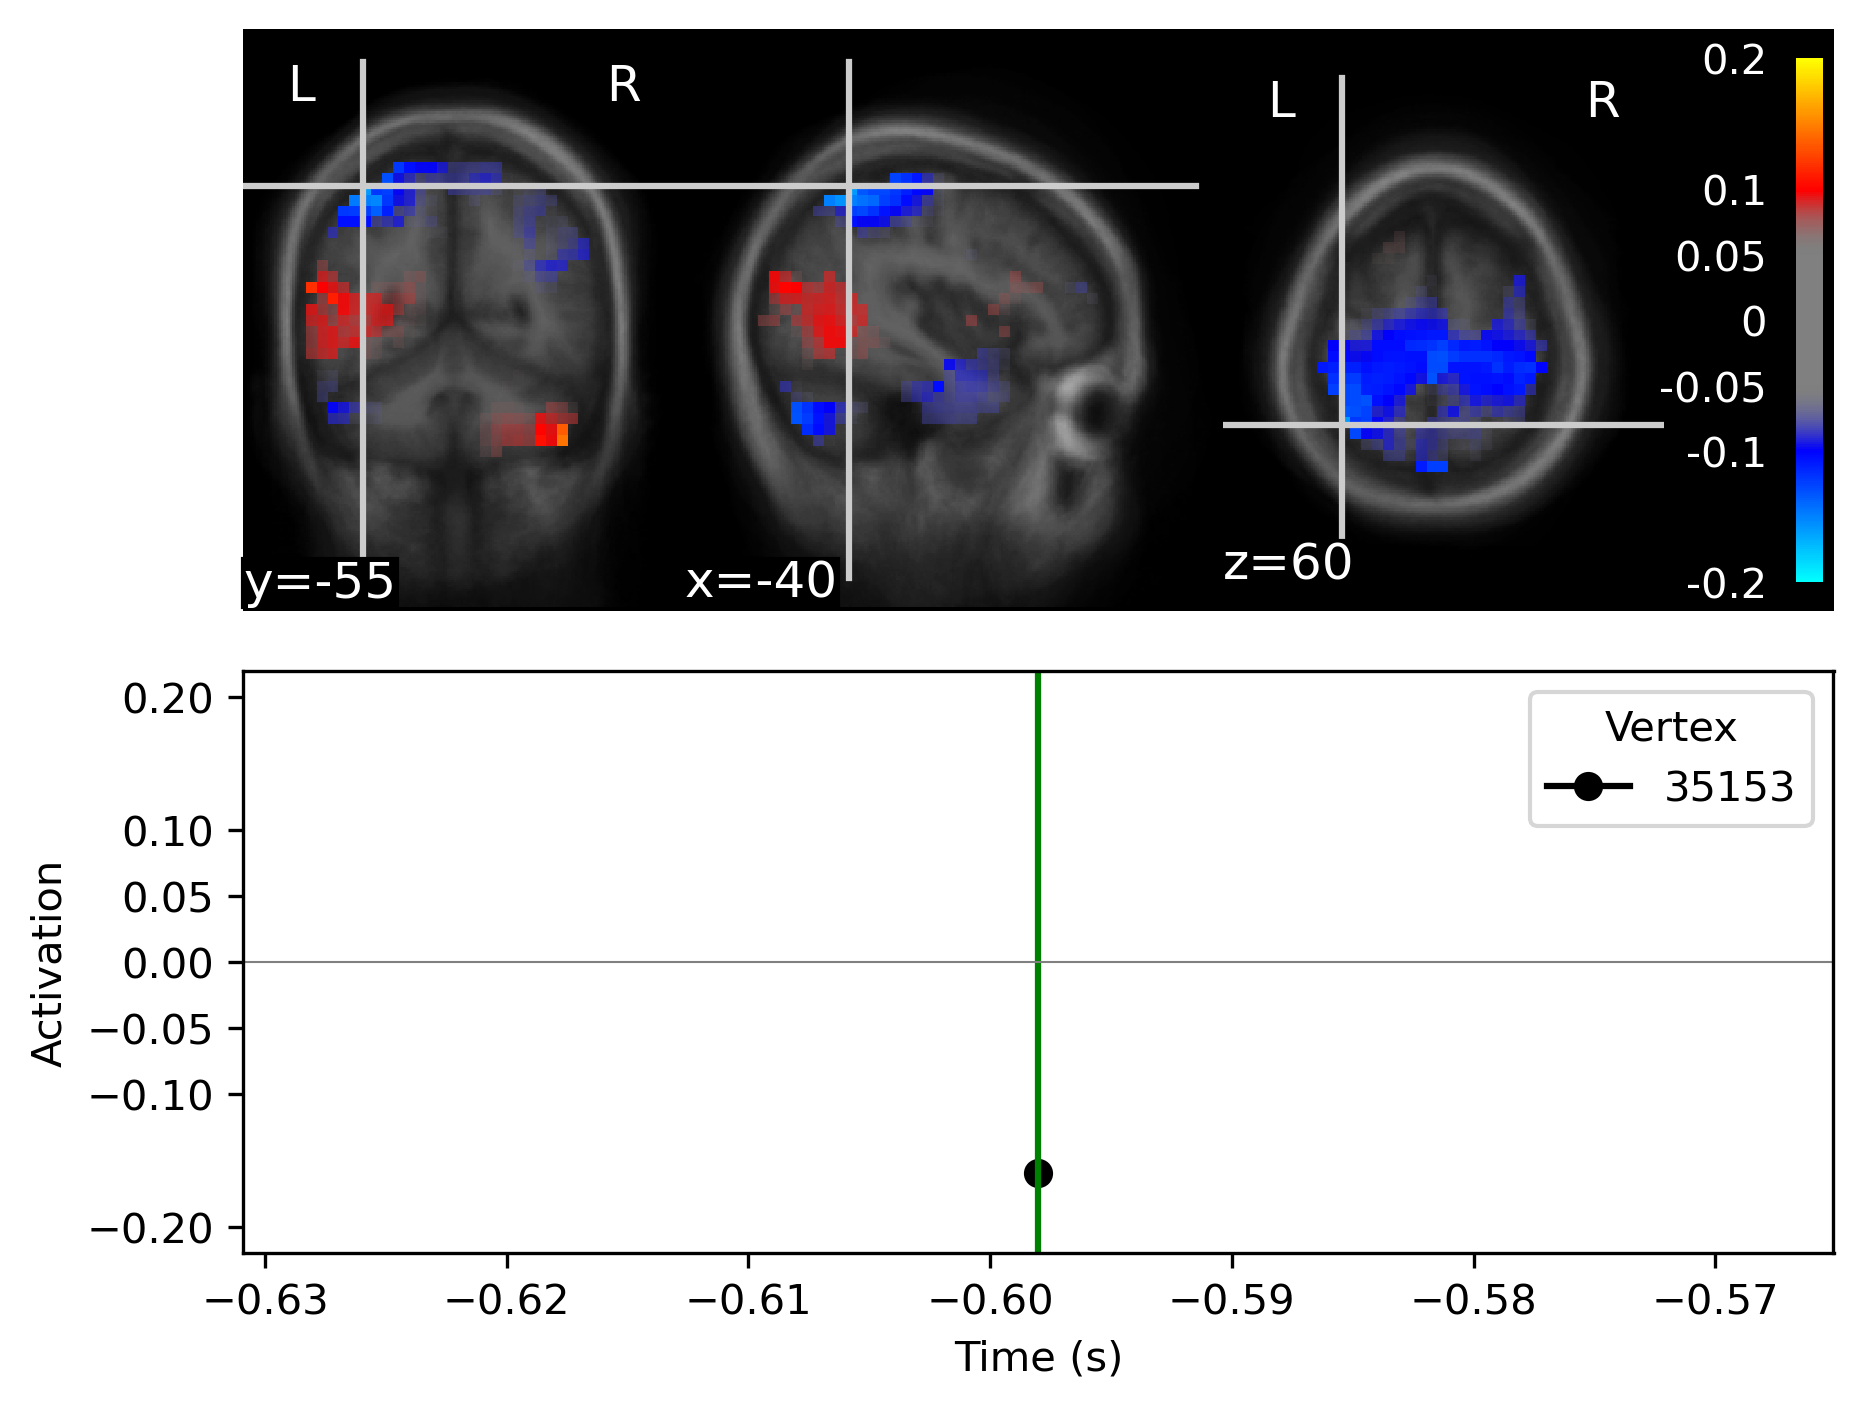

In [15]:
lims = [0.05, 0.1, 0.2]
kwargs = dict(src=src, subject=subject, subjects_dir=subjects_dir,
             verbose=True)

n_subjects = len(stcs)
data = np.mean([stc.data for stc in stcs], axis=0) #combine to individuals stcs to Grand Mean

# Create mean stc
mean_stc = stcs[0].copy()
mean_stc.data = data

all_stc_mean = mean_stc.copy().crop(-1, -0.2).mean() #crop interesting period and mean across time


# Viz
fig = all_stc_mean.plot(mode='stat_map', clim=dict(kind='value', pos_lims=lims), **kwargs)

In [16]:
all_stc_mean

<VolSourceEstimate | 14629 vertices, subject : fsaverage, tmin : -598.0 (ms), tmax : -598.0 (ms), tstep : 804.0 (ms), data shape : (14629, 1), ~229 kB>

In [20]:
# find the active vertices

trashhold = 0.1
vertices = all_stc_mean.vertices[0]
stc_data = all_stc_mean.data[:, 0] 
active_vertices = vertices[np.where(stc_data > trashhold)[0]]  # The threshold can be set at your discretion

# find the indexes of active vertices
active_indices = np.isin(vertices, active_vertices)

# Extracting values for active vertices
active_values = stc_data[active_indices]

# Sorting values and corresponding vertices in descending order
sorted_indices = np.argsort(active_values)
sorted_active_vertices = active_vertices[sorted_indices]
sorted_active_values = active_values[sorted_indices]
sorted_active_vertices



array([10852, 22437, 23372, 10982, 24886,  6720,  9591,  6855,  9694,
        9662,  8371,  5535, 10817, 24885, 10984, 10818, 22470,  9661,
       23599, 12299, 12298,  9627,  9628, 13652,  9626, 18387,  5568,
        9660, 10981,  9693,  9625, 17101,  9624,  9692, 23757, 18355,
       18354, 12265, 10911,  9659, 13653, 10978, 10980, 10944, 12332,
       12300, 10784,  9658, 10979, 12266, 10947, 10912, 10913, 12267,
       10945, 12366, 22280, 10946,  5601, 13687, 23631, 13654, 23565,
        5602, 23598,  6889, 13688,  6921, 11017,  8208,  6954,  9597,
        6891,  9630,  6922,  6923,  8209,  6955,  8241,  8210,  8242,
        9530,  9463,  9529,  6857,  9497,  8175,  8176,  6888,  9496,
        5570,  6825])

In [21]:
# find MNI coordinates of active_vertices
mri_coords = mne.vertex_to_mni(sorted_active_vertices, hemis=0, subject=subject, subjects_dir=subjects_dir)

In [22]:
# associate coordinates with structures using the AAL atlas

from nilearn import datasets as nilearn_ds
from nilearn import image
from nilearn.image import coord_transform, load_img
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn._utils.ndimage import largest_connected_component
from nilearn.regions import connected_regions
from nilearn.plotting import find_parcellation_cut_coords


aal_atlas = nilearn_ds.fetch_atlas_aal()
atlas_img = load_img(aal_atlas.maps)

/Users/amina/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [23]:
label_coords_mni = find_parcellation_cut_coords(atlas_img)

In [24]:
# associate of vertecies coordinates with atlas labels coordinates based on min distance 
vertex_labels = []
for coord_mni in mri_coords_cont:
    distances = cdist([coord_mni], label_coords_mni)
    sorted_indices = np.argsort(distances[0])
    sorted_labels = [aal_atlas.labels[idx] for idx in sorted_indices]
    vertex_labels.append(sorted_labels) # append sorted list of labels to each vertex

NameError: name 'mri_coords_cont' is not defined

In [116]:
for i, sorted_labels in enumerate(vertex_labels_cont):
    print(f"Vertex {sorted_active_vertices_cont[i]} is closest to regions (sorted by distance): {sorted_labels[0]}")

Vertex 29380 is closest to regions (sorted by distance): Angular_L
Vertex 29413 is closest to regions (sorted by distance): Occipital_Mid_L
Vertex 30667 is closest to regions (sorted by distance): Frontal_Sup_L
Vertex 28059 is closest to regions (sorted by distance): Cingulum_Post_L
Vertex 30701 is closest to regions (sorted by distance): Supp_Motor_Area_L
Vertex 30668 is closest to regions (sorted by distance): Frontal_Sup_L
Vertex 29347 is closest to regions (sorted by distance): Temporal_Mid_L
Vertex 28060 is closest to regions (sorted by distance): Cingulum_Post_L
Vertex 28126 is closest to regions (sorted by distance): Cingulum_Mid_L
Vertex 31955 is closest to regions (sorted by distance): Temporal_Inf_L
Vertex 29381 is closest to regions (sorted by distance): Angular_L
Vertex 29346 is closest to regions (sorted by distance): Temporal_Mid_L
Vertex 28093 is closest to regions (sorted by distance): Thalamus_L
Vertex 29314 is closest to regions (sorted by distance): Heschl_L
Vertex 2